<a href="https://colab.research.google.com/github/partlygloudy/fcn-cropland-segmentation/blob/master/fcn_cropland_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install TensorFlow for GPU and unzip the training and testing datasets

In [1]:
# # Install GPU version of tensorflow on to VM
!pip install tensorflow-gpu

    100% |████████████████████████████████| 345.2MB 58kB/s 


In [2]:
# Unzip image archives
!unzip train.zip
!unzip test.zip

Archive:  train.zip
   creating: train/
   creating: train/usda_nass/
  inflating: train/usda_nass/012140.jpg  
  inflating: train/usda_nass/009369.jpg  
  inflating: train/usda_nass/006451.jpg  
  inflating: train/usda_nass/009432.jpg  
  inflating: train/usda_nass/004617.jpg  
  inflating: train/usda_nass/006959.jpg  
  inflating: train/usda_nass/002109.jpg  
  inflating: train/usda_nass/012124.jpg  
  inflating: train/usda_nass/007290.jpg  
  inflating: train/usda_nass/000910.jpg  
  inflating: train/usda_nass/002796.jpg  
  inflating: train/usda_nass/004995.jpg  
  inflating: train/usda_nass/007845.jpg  
  inflating: train/usda_nass/009546.jpg  
  inflating: train/usda_nass/010803.jpg  
  inflating: train/usda_nass/011201.jpg  
  inflating: train/usda_nass/006306.jpg  
  inflating: train/usda_nass/003686.jpg  
  inflating: train/usda_nass/000811.jpg  
  inflating: train/usda_nass/001396.jpg  
  inflating: train/usda_nass/008431.jpg  
  inflating: train/usda_nass/007726.jpg  
  infl

## Import TensorFlow and load pre-trained VGG16

In [3]:
#Import tensorflow / keras packages
import tensorflow.keras as keras
from tensorflow.keras.applications import vgg16
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.regularizers import l2

# Load pretrained VGG 16 model (without the dense layers)
base_model = vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(224,224,3))

Instructions for updating:
Colocations handled automatically by placer.
58892288/58889256 [==============================] - 1s 0us/step


## Add additional layers to the model to form FCN architecture

In [0]:
l2_reg_val = 0.05

# Convolution layer to replace first Dense layer in original model
layer_fc6 = Convolution2D(
    4096, kernel_size=(7,7), padding="same", 
    activation="relu", name="fc6",
    kernel_initializer=TruncatedNormal(stddev=0.01),
    kernel_regularizer=l2(l2_reg_val))(base_model.output)

# Convolution layer to replace second Dense layer in original model
layer_fc7 = Convolution2D(
    4096, kernel_size=(1,1), padding = "same",
    activation = "relu", name = "fc7",
    kernel_initializer=TruncatedNormal(stddev=0.01),
    kernel_regularizer=l2(l2_reg_val))(layer_fc6)

# First "Score" layer, produces low resolution 'heatmap' for each pixel class
layer_score_1 = Convolution2D(
    1, kernel_size=(1,1), padding="same", 
    activation="relu", name="score_1", 
    kernel_initializer=TruncatedNormal(stddev=0.01),
    kernel_regularizer=l2(l2_reg_val))(layer_fc7)

# Second "Score" layer - input to first skip connection
layer_score_2 = Convolution2D(
    1, kernel_size=(1,1), padding="same", 
    activation=None, name="score_2", 
    kernel_initializer=TruncatedNormal(stddev=0.01),
    kernel_regularizer=l2(l2_reg_val))(base_model.get_layer("block4_pool").output)

# Third "Score" layer - inpute to second skip connection
layer_score_3 = Convolution2D(
    1, kernel_size=(1,1), padding="same", 
    activation=None, name="score_3", 
    kernel_initializer=TruncatedNormal(stddev=0.01),
    kernel_regularizer=l2(l2_reg_val))(base_model.get_layer("block3_pool").output)

# Upsample first score layer x 2 to increase resolution
layer_upsample_1 = Conv2DTranspose(
    1, kernel_size=(4,4), strides=(2,2), 
    padding="same", activation=None, name="upsample_1", 
    kernel_initializer=TruncatedNormal(stddev=0.01),
    kernel_regularizer=l2(l2_reg_val))(layer_score_1)

# Add first upsampling to block 4 pool score (score 2)
layer_add_1 = Add()([layer_score_2, layer_upsample_1])

# Upsample output of the addition layer x 2 to increase resolution
layer_upsample_2 = Conv2DTranspose(
    1, kernel_size=(4,4), strides=(2,2), 
    padding="same", activation=None, name="upsample_2", 
    kernel_initializer=TruncatedNormal(stddev=0.01),
    kernel_regularizer=l2(l2_reg_val))(layer_add_1)

# Add second upsampling to block 3 pool score (score 3)
layer_add_2 = Add()([layer_score_3, layer_upsample_2])

# Upsample output of second addition layer x 8 to increase resolution to match input resolution
layer_upsample_final = Conv2DTranspose(
    1, kernel_size=(16,16), strides=(8,8), 
    padding="same", activation="sigmoid", name="upsample_final", 
    kernel_initializer=TruncatedNormal(stddev=0.01),
    kernel_regularizer=l2(l2_reg_val))(layer_add_2)

# Full model
model = Model(base_model.input, layer_upsample_final)
# print(model.summary())

## Load in the training data

In [0]:
import os
import cv2
import numpy as np

# Get list of all training examples
filenames = os.listdir("train/copernicus")

# Load all the validation data
val_inputs = []
val_outputs =[]

# Add inputs and outputs to corresponding numpy arrays
for i in range(len(filenames)):

  fname = filenames[i]

  # Input image
  input_img = cv2.imread("train/copernicus/" + fname)
  val_inputs.append(input_img)

  # Output image
  output_img = cv2.imread("train/usda_nass/" + fname, 0) / 255.0
  output_img[output_img > 0.5] = 1.0
  output_img[output_img <= 0.5] = 0.0
  output_img = np.reshape(output_img, (224, 224, 1))
  val_outputs.append(output_img)

# Stack each input image to form input, output 4D tensors
val_inputs = np.stack(val_inputs, axis=0)
val_outputs = np.stack(val_outputs, axis=0)




## Compile and fit the model



In [6]:
# Compile model
model.compile(loss=keras.losses.BinaryCrossentropy(),
             optimizer=keras.optimizers.Adam(lr=1.0e-3),
             metrics=["accuracy"])

Instructions for updating:
Use tf.cast instead.


In [7]:
# Fit model
train_hist = model.fit(
    val_inputs, 
    val_outputs, 
    validation_split=0.2, 
    epochs=30, 
    verbose=1)

Train on 8470 samples, validate on 2118 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/30
8470/8470 [==============================] - 311s 37ms/sample - loss: 10.3085 - acc: 0.7767 - val_loss: 0.4076 - val_acc: 0.8033
Epoch 2/30
8470/8470 [==============================] - 286s 34ms/sample - loss: 0.3820 - acc: 0.8280 - val_loss: 0.3860 - val_acc: 0.8333
Epoch 3/30
8470/8470 [==============================] - 286s 34ms/sample - loss: 0.3309 - acc: 0.8533 - val_loss: 0.3069 - val_acc: 0.8644
Epoch 4/30
8470/8470 [==============================] - 285s 34ms/sample - loss: 0.3085 - acc: 0.8657 - val_loss: 0.3164 - val_acc: 0.8736
Epoch 5/30
8470/8470 [==============================] - 286s 34ms/sample - loss: 0.2919 - acc: 0.8732 - val_loss: 0.2760 - val_acc: 0.8799
Epoch 6/30
8470/8470 [==============================] - 285s 34ms/sample - loss: 0.2797 - acc: 0.8797 - val_loss: 0.2608 - val_acc: 0.8894
Epoch 7/30
8470/8470 [==============================] - 285s 34ms/sam

## Display input, output, and ground truth images

2648


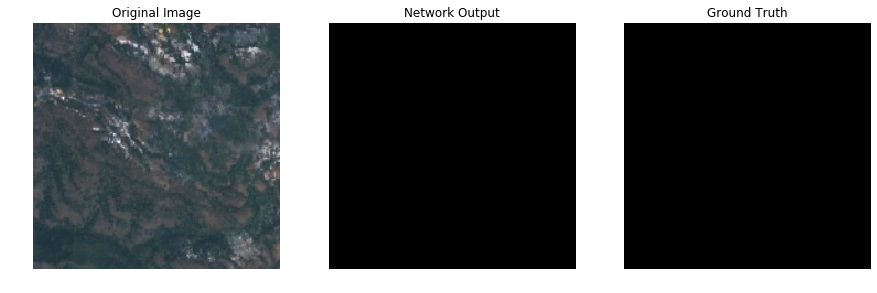

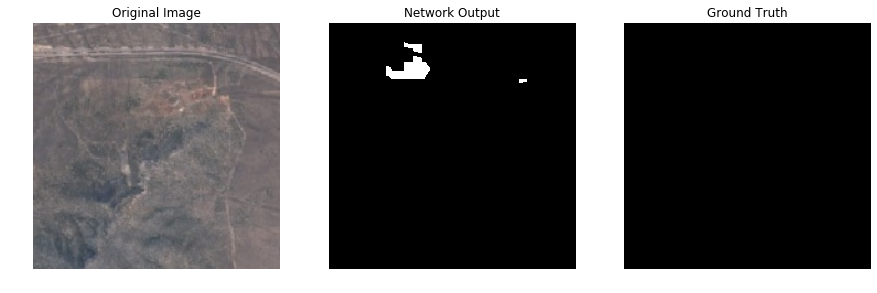

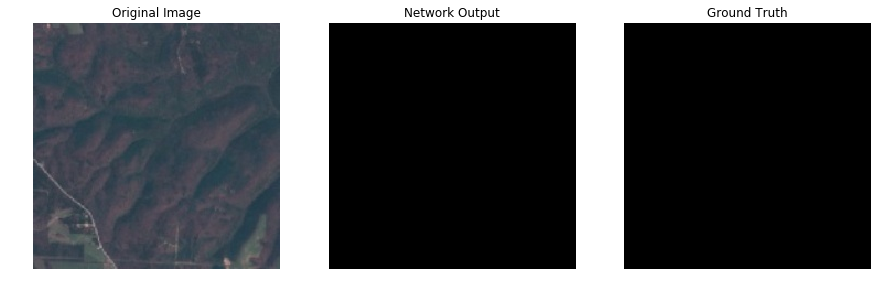

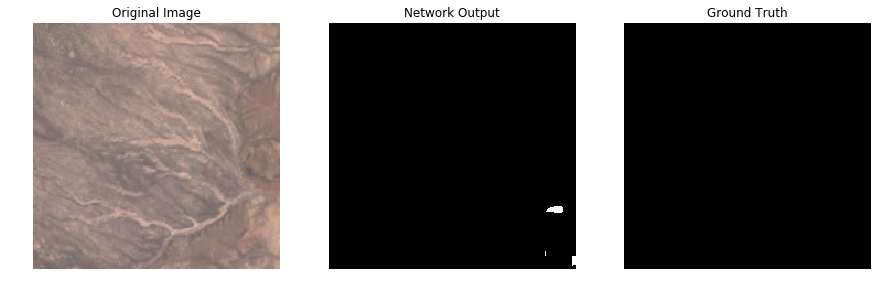

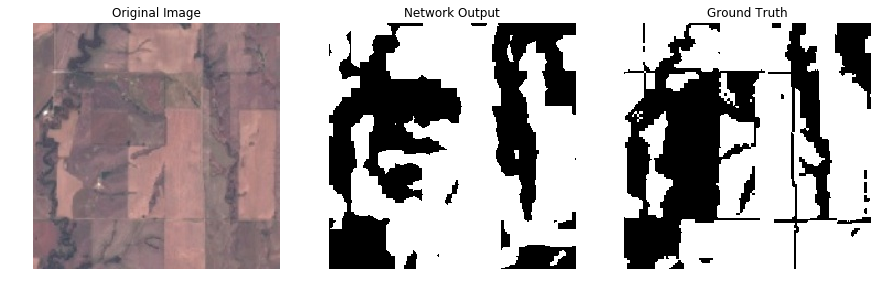

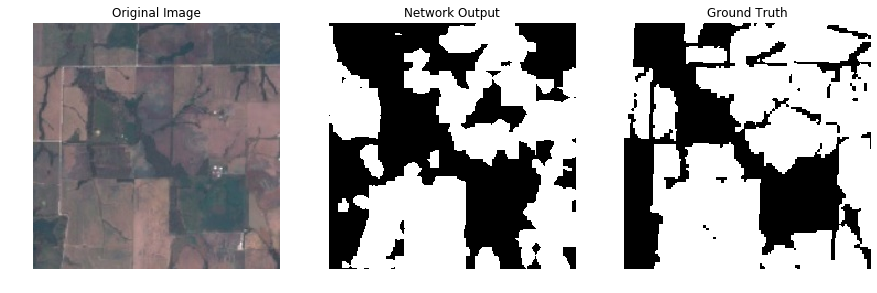

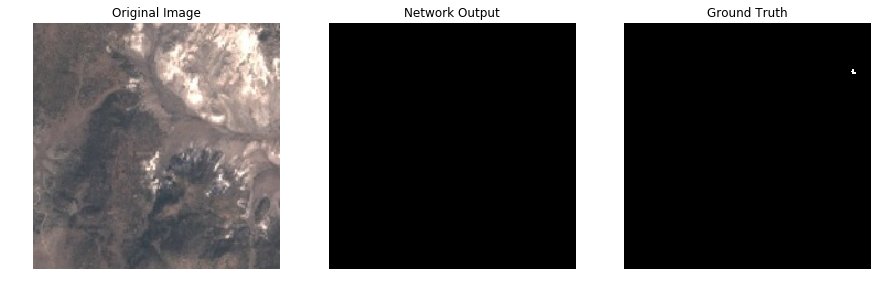

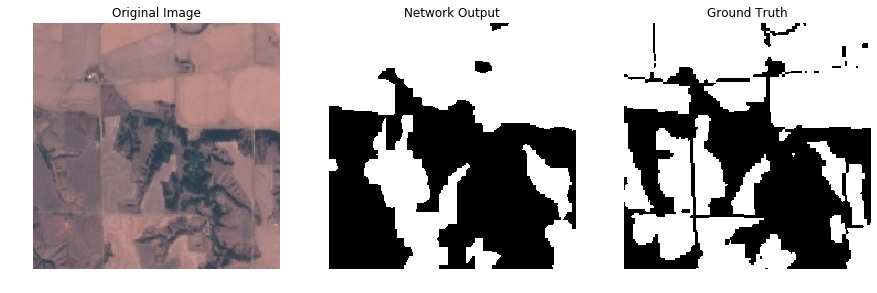

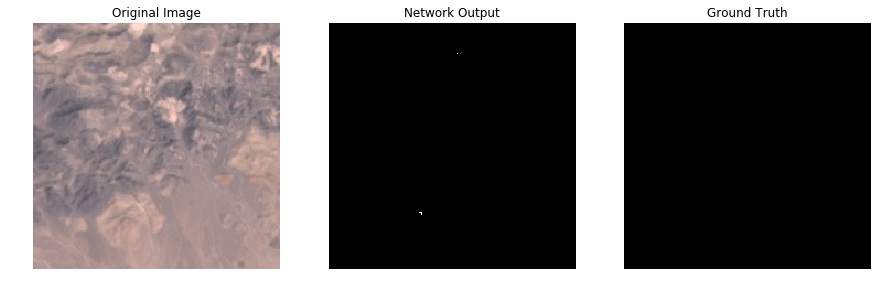

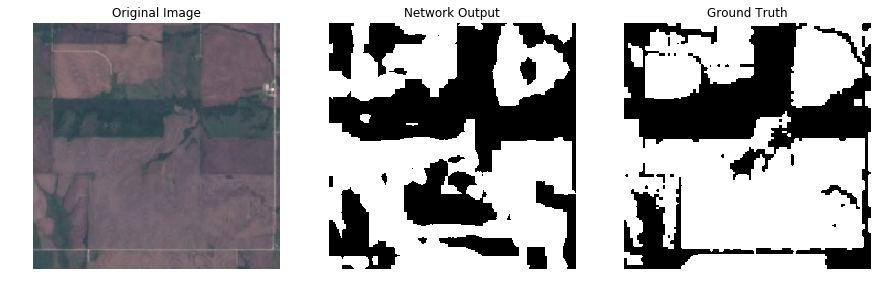

In [8]:
from matplotlib import pyplot as plt

# Load a few examples from testing set
test_fnames = os.listdir("test/copernicus")

print(len(test_fnames))

test_inputs = []
test_ground_truths = []

start = 0
for fname in test_fnames[start:start+10]:
  
  # Original image
  input_img = cv2.imread("test/copernicus/" + fname)
  test_inputs.append(input_img)

  # Get ground truth output
  output_img = cv2.imread("test/usda_nass/" + fname, 0) / 255.0
  output_img[output_img > 0.5] = 1.0
  output_img[output_img <= 0.5] = 0.0
  output_img = np.reshape(output_img, (224, 224, 1))
  test_ground_truths.append(output_img)
  
# Stack inputs into a 4D tensor
test_inputs = np.stack(test_inputs, axis=0)  

# Compute outputs
test_outputs = model.predict(test_inputs)
output_imgs = []
for i in range(test_outputs.shape[0]):
  output = test_outputs[i, :, :, 0]
  output[output > 0.5] = 1.0
  output[output < 0.5] = 0.0
  output_imgs.append(output)

# Plot each set

for i in range(test_inputs.shape[0]):
  
  # Create new set of subplots
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,15))
  
  # Plot each version of image
  im_orig = ax1.imshow(cv2.cvtColor(test_inputs[i, :, :, :], cv2.COLOR_BGR2RGB))
  im_out = ax2.imshow(output_imgs[i], cmap='gray')
  im_grnd = ax3.imshow(test_ground_truths[i][:, :, 0], cmap='gray')
  
  # Turn off axis ticks
  ax1.set_axis_off()
  ax2.set_axis_off()
  ax3.set_axis_off()
  
  # Add titles to subplots  
  ax1.set_title("Original Image")
  ax2.set_title("Network Output")
  ax3.set_title("Ground Truth")
  
  plt.show()
  
  
  

## Plot learning curves

ValueError: ignored

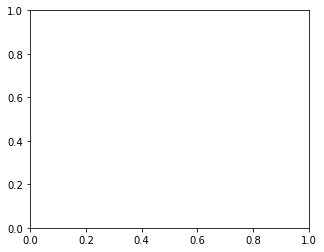

In [9]:
plt.figure(figsize=(5,4))
plt.plot([i for i in range(1, 21)], train_hist.history["acc"])
plt.plot([i for i in range(1, 21)], train_hist.history["val_acc"])
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Training", "Validation"])
plt.xlim(1, 30)
plt.ylim(0.7, 1.0)
plt.plot()

In [0]:
plt.figure(figsize=(5,4))
plt.plot([i for i in range(1, 21)], train_hist.history["loss"])
plt.plot([i for i in range(1, 21)],train_hist.history["val_loss"])
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Training", "Validation"])
plt.xlim(1, 30)
plt.ylim(0, 0.4)
plt.plot()

## Test the model on the training data

In [0]:
# Get list of all training examples
filenames = os.listdir("test/copernicus")

# Load all the testing data 
# (use the same variables so training data is freed from memory)
val_inputs = []
val_outputs =[]

# Add inputs and outputs to corresponding numpy arrays
for i in range(len(filenames)):

  fname = filenames[i]

  # Input image
  input_img = cv2.imread("test/copernicus/" + fname)
  val_inputs.append(input_img)

  # Output image
  output_img = cv2.imread("test/usda_nass/" + fname, 0) / 255.0
  output_img[output_img > 0.5] = 1.0
  output_img[output_img <= 0.5] = 0.0
  output_img = np.reshape(output_img, (224, 224, 1))
  val_outputs.append(output_img)

# Stack each input image to form input, output 4D tensors
val_inputs = np.stack(val_inputs, axis=0)
val_outputs = np.stack(val_outputs, axis=0)

eval_metrics = model.evaluate(val_inputs, val_outputs, batch_size=32)
print("Test set loss: \t" + str(eval_metrics[0]))
print("Test set acc.: \t" + str(eval_metrics[1]))